# Hospital placement set covering problem: Basic model

Plan:
1. Place equidistant points on a map of Vancouver to indicate possible locations for "hospitals"
2. Consider each of these points as location that must be covered as well
3. Run the set covering algorithm to see what happens

In [2]:
!! pip3 install -U numpy scipy
!! pip3 install -U googlemaps
!! pip3 install -U requests
!! pip3 install -U Pillow
!! pip3 install opencv-python
!! pip3 install -U scikit-image

['Requirement already up-to-date: requests in /home/lily/.local/lib/python3.8/site-packages (2.28.1)',
 'Requirement already satisfied, skipping upgrade: urllib3<1.27,>=1.21.1 in /home/lily/.local/lib/python3.8/site-packages (from requests) (1.26.2)',
 'Requirement already satisfied, skipping upgrade: certifi>=2017.4.17 in /home/lily/.local/lib/python3.8/site-packages (from requests) (2020.12.5)',
 'Requirement already satisfied, skipping upgrade: idna<4,>=2.5 in /home/lily/.local/lib/python3.8/site-packages (from requests) (2.10)',
 'Requirement already satisfied, skipping upgrade: charset-normalizer<3,>=2 in /home/lily/.local/lib/python3.8/site-packages (from requests) (2.1.1)']

In [6]:
import googlemaps
import requests
from IPython.display import display
import math
import numpy as np
from scipy.optimize import linprog
from PIL import Image
import io
import cv2

api_key = open("googlemaps-apikey.txt", "r").read()
client = googlemaps.Client(key=api_key)


In [18]:
def get_map(center, markers=[], marker_color="blue", zoom=13, fill=False):
    static_map_url = "https://maps.googleapis.com/maps/api/staticmap?"
    lat,long = center
    center = str(lat)+","+str(long)
    req = f"{static_map_url}center={center}&zoom={str(zoom)}&size=400x400&key={api_key}&sensor=false"
    if fill:
        path = "&path=color:0x00000000|weight:5|fillcolor:0xf55742|" + "|".join([str(lat)+","+str(long) for lat,long in markers])
        marker = f"&markers=color:red|{center}"
        req = req + path + marker
    else:
        markers = f"&markers=color:{marker_color}|" + "|".join([str(lat)+","+str(long) for lat,long in markers])
        req = req + markers
    # print(req)
    r = requests.get(req)
    if "X-Staticmap-API-Warning" in r.headers:
        print(r.headers["X-Staticmap-API-Warning"])
        return None
    return Image.open(io.BytesIO(r.content))

In [8]:
# parsing the distance matrix
# times = client.distance_matrix(origins=center, destinations=circle)
# print("\n".join([str([elt["duration"]["text"] for elt in row["elements"]]) for row in times["rows"]]))

NINE_MINS=9*60
EIGHT_MINS_THIRTY_SEC=8.5*60
NINE_MINS_THIRTY_SEC=9.5*60

# lat,long -> encoded polyline representing the region
def distance_coverable(center, image_center=None):
    if image_center == None:
        image_center = center
    n = 15
    r = 0.02
    def circle_offsets():
        offsets =[]
        for i in range(n):
            deg = i/n * 2 * math.pi
            offsets.append([math.cos(deg)*r, math.sin(deg)*r])
        return offsets

    circle = [[center[0] + offset[0], center[1] + offset[1]] for offset in circle_offsets()]
    # display_map(center, markers=circle,zoom=11, fill=True)
    unchanged = False
    # center_str = str(center[0]) + "," + str(center[1])
    max_iterations = 5
    num_iter = 0
    while num_iter < max_iterations and not unchanged:
        # print("---")
        num_iter += 1
        unchanged = True
        times = client.distance_matrix(origins=center, destinations=circle)
        matrix = [[elt["duration"]["value"] for elt in row["elements"]] for row in times["rows"]]
        pairs = zip(circle, matrix[0])
        circle = []
        for i, ((lat, long), time) in enumerate(pairs):
            deg = i/n * 2 * math.pi
            old_r = (lat - center[0])/math.cos(deg)
            # print(f"time {time}")
            if time < EIGHT_MINS_THIRTY_SEC or time > NINE_MINS_THIRTY_SEC:
                if time == 0:
                    ratio = 10
                else:
                    ratio = NINE_MINS/time
                # print(f"moving {ratio}")
                new_r = old_r * ratio
                circle.append([center[0] +math.cos(deg)*new_r, center[1] + math.sin(deg)*new_r])
                unchanged = False
            else:
                # print("done")
                circle.append([lat,long])
    # print(f"iterations taken = {num_iter}")
    return get_map(image_center, markers=circle,zoom=11, fill=True)


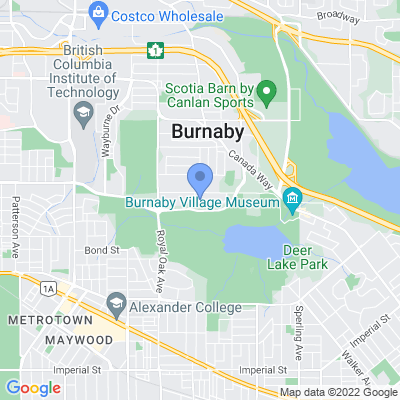

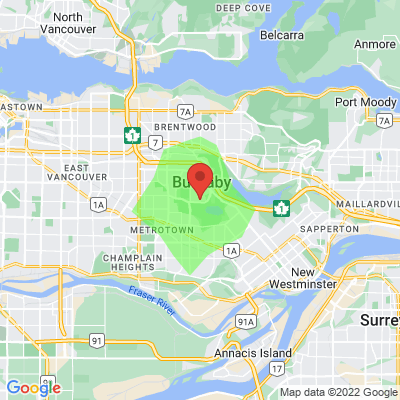

In [9]:
test_positions_burnaby = [
    (49.240982, -122.981740)
]

display(get_map((49.240982, -122.981740), markers=test_positions_burnaby))
display(distance_coverable((49.240982, -122.981740)))

In [148]:
def is_in_city(point, city_name=None):
    res = client.reverse_geocode(point, result_type=["street_address"])
    if res == []:
        return False
    if city_name == None:
        return "formatted_address" in res[0]
    address = res[0]["formatted_address"]
    return city_name in address

-
-
-
-
-
-
new
-
-
-
-
-
-
-
-
new
-


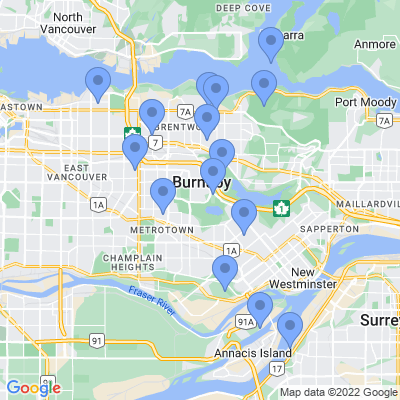

In [150]:
import random 
test_problem_burnaby_center = (49.240982, -122.981740)
n = 15
test_problem_burnaby_locations= []
for _ in range(n):
    point = [round(test_problem_burnaby_center[0] + random.uniform(-0.07, 0.07), 6), round(test_problem_burnaby_center[1] + random.uniform(-0.07, 0.07), 6)]
    while not (is_in_city(point)):
        print("new")
        point = [round(test_problem_burnaby_center[0] + random.uniform(-0.07, 0.07), 6), round(test_problem_burnaby_center[1] + random.uniform(-0.07, 0.07), 6)]
    test_problem_burnaby_locations.append(point)
    print("-")

display(get_map(test_problem_burnaby_center, markers=test_problem_burnaby_locations,zoom=11.5))
# print(test_problem_burnaby_locations)


In [152]:
def make_set_covering_problem(positions):
    positions = [str(lat) + "," + str(long) for lat,long in positions]
    covering_matrix = np.array([])
    ten_mins = 60*10
    for start in positions:
        # print(f"starting from {start}")
        matrix = client.distance_matrix(origins=start, destinations=positions)
        times = [[elt["duration"]["value"] for elt in row["elements"]] for row in matrix["rows"]][0]
        covered = [1 if t < NINE_MINS else 0 for t in times]
        covering_matrix = np.hstack((covering_matrix, covered))
    return covering_matrix.reshape(len(positions), len(positions))

In [153]:
matrix = make_set_covering_problem(test_problem_burnaby_locations)
print(matrix)

[[1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1.]
 [0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1.]
 [0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1.]]


In [154]:
c = np.ones(len(test_problem_burnaby_locations))
b = -np.ones(len(test_problem_burnaby_locations))
A = -matrix
bounds = [(0,1) for _ in test_problem_burnaby_locations]
print(A)
print(b)
print(c)
solution = linprog(c, A_ub=A, b_ub=b, bounds=bounds, integrality=np.ones(len(test_problem_burnaby_locations)))
print(solution)
linprog_solution = []
for i,chosen in enumerate(solution.x):
    if chosen == 1:
        linprog_solution.append(i)
print(linprog_solution)

[[-1. -0. -0. -1. -0. -0. -1. -0. -0. -0. -0. -0. -0. -0. -0.]
 [-0. -1. -0. -0. -0. -1. -0. -0. -0. -0. -1. -1. -0. -0. -0.]
 [-0. -0. -1. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -1.]
 [-1. -0. -0. -1. -0. -1. -0. -1. -0. -0. -1. -1. -0. -0. -0.]
 [-0. -0. -0. -0. -1. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.]
 [-0. -1. -0. -1. -0. -1. -0. -0. -0. -0. -1. -1. -0. -1. -0.]
 [-1. -0. -0. -0. -0. -0. -1. -0. -0. -0. -0. -0. -0. -0. -1.]
 [-0. -0. -0. -1. -0. -0. -0. -1. -0. -0. -0. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -0. -0. -0. -0. -1. -0. -0. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -0. -0. -0. -0. -0. -1. -0. -0. -0. -0. -0.]
 [-0. -1. -0. -1. -0. -1. -0. -0. -0. -0. -1. -1. -0. -1. -1.]
 [-0. -1. -0. -1. -0. -1. -0. -0. -0. -0. -1. -1. -0. -1. -0.]
 [-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -1. -0. -0.]
 [-1. -0. -1. -1. -0. -1. -0. -0. -0. -0. -1. -0. -0. -1. -1.]
 [-0. -0. -1. -0. -0. -0. -1. -0. -0. -0. -1. -0. -0. -1. -1.]]
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -

In [155]:
# greedy solver -> alternative to linprog to see if it makes a difference

def greedy_solve(matrix):
    taken = []
    internal = np.copy(matrix)
    while internal.shape[0] != 0:
        # print(internal)
        values = np.sum(internal, axis=0)
        choice = np.argmax(values)
        taken.append(choice)
        # remove the rows that are now covered
        covered = internal[:,choice]
        to_delete = []
        for i,is_covered in enumerate(covered):
            if is_covered == 1:
                to_delete.append(i)
        internal = np.delete(internal, to_delete, axis=0)
        # remove the column for this choice
        # internal = np.delete(internal, (choice), axis=1)
    return sorted(taken)

In [119]:
def pil_to_cv(im):
    return cv2.cvtColor(np.array(im.convert('RGB')), cv2.COLOR_RGB2BGR)

def cv_to_pil(im):
    return Image.fromarray(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

# from skimage.metrics import structural_similarity

def overlay_diffs(base, after):
    difference = cv2.subtract(base, after)
    Conv_hsv_Gray = cv2.cvtColor(difference, cv2.COLOR_BGR2GRAY)
    ret, mask = cv2.threshold(Conv_hsv_Gray, 0, 255,cv2.THRESH_BINARY_INV |cv2.THRESH_OTSU)
    difference[mask != 255] = [0, 0, 255]
    masked = base.copy()
    masked[mask != 255] = [0, 0, 255]
    # masked[mask != 255] *= 0.5
    # masked[mask != 255] += 0.5*[0, 0, 255]
    # masked = np.multiply(masked, 0.5, where=mask != 255, casting="unsafe")
    # masked = np.add(masked, 0.5*[0, 0, 255], where=mask != 255)
    # # masked = [a*0.5 + [0, 0, 255]*0.5 if np.all(m != 255) else a for a,m in zip(base, mask)]
    return cv2.addWeighted(base, 0.5, masked, 0.5, 0.0)

    # Convert images to grayscale
    # base_gray = cv2.cvtColor(base, cv2.COLOR_BGR2GRAY)
    # after_gray = cv2.cvtColor(after, cv2.COLOR_BGR2GRAY)
    # display(cv_to_pil(base))
    # display(cv_to_pil(after))
    # # Compute SSIM between the two images
    # (score, diff) = structural_similarity(base_gray, after_gray, full=True)
    # display(Image.fromarray(diff))
    # print("Image Similarity: {:.4f}%".format(score * 100))

    # # Threshold the difference image, followed by finding contours to
    # # obtain the regions of the two input images that differ
    # thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV)[1]
    # contours = cv2.findContours(thresh.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # contours = contours[0] if len(contours) == 2 else contours[1]

    # overlayed = base.copy()

    # for c in contours:
    #     area = cv2.contourArea(c)
    #     if area > 40:
    #         cv2.drawContours(overlayed, [c], 0, (0,255,0), -1)
    # return overlayed


def display_solution(center, problem, chosen_indicies, show_coverage=False):
    base_image = pil_to_cv(get_map(center,zoom=11.5))
    chosen_points = []
    image = pil_to_cv(get_map(center, markers=problem,zoom=11.5))
    coverage_images = []
    for i in chosen_indicies:
        if show_coverage:
            # googlemaps requires this to be a tuple... weird
            lat,long = problem[i]
            coverage_images.append(pil_to_cv(distance_coverable((lat, long), image_center=center)))
            # show_coverage = False
        chosen_points.append(problem[i])
    print(chosen_points)
    solution_img = pil_to_cv(get_map(center, markers=chosen_points, marker_color="red", zoom=11.5))
    image = cv2.addWeighted(image, 0.5, solution_img, 0.5, 0.0)
    display(cv_to_pil(image))
    for cov_im in coverage_images:
        display(cv_to_pil(cov_im))
        image = overlay_diffs(image, cov_im)
    return cv_to_pil(image)
    # return cv_to_pil(overlay_diffs(image, solution_img))
    # image = cv2.addWeighted(image, 0.5, solution_img, 0.5, 0.0)
    # image = mask_images(image, solution_img)
    # for im in coverage_images:
        # image = cv2.addWeighted(image, 0.5, im, 0.5, 0.0)
        # image = mask_images(image, im)
    # cv2.imshow('solution', image)
    # return cv_to_pil(cv2.absdiff(image, solution_img))
    # return cv_to_pil(image)

[1, 3, 4, 8, 9, 12, 14]


/home/lily/.local/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  self.im.convert_transparent(mode, self.info["transparency"])


[[49.282748, -122.937544], [49.269789, -123.014546], [49.301878, -122.933145], [49.18285, -122.940542], [49.199575, -122.96439], [49.174095, -122.919828], [49.243376, -122.972663]]


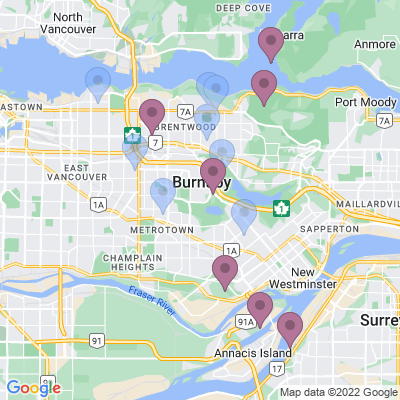

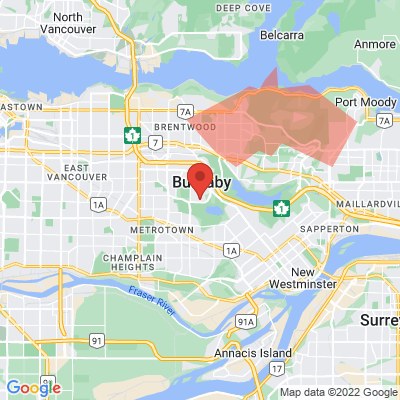

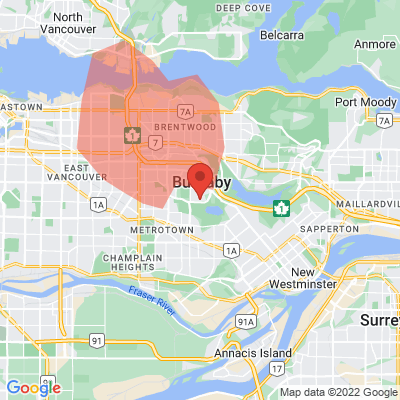

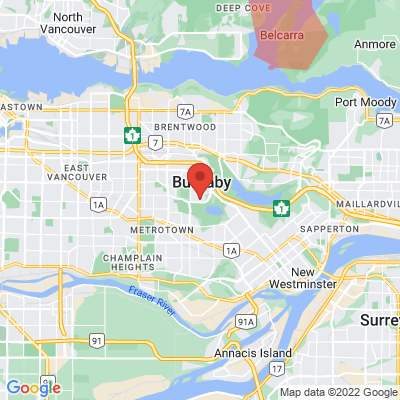

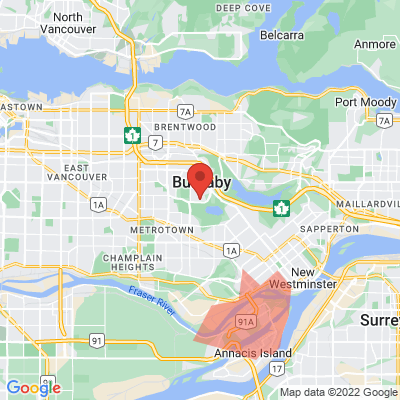

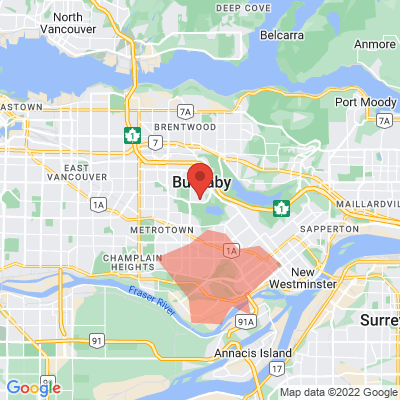

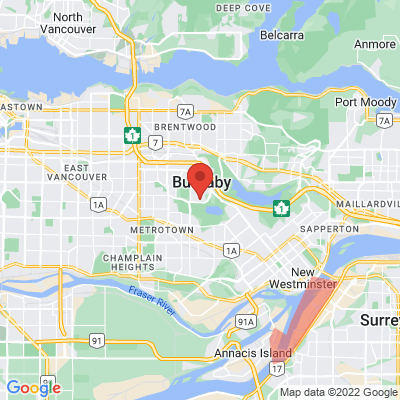

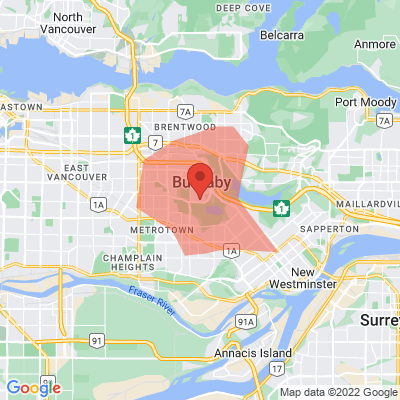

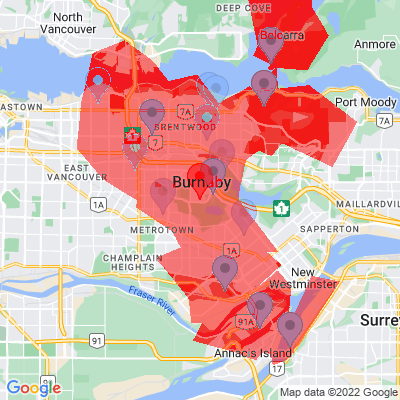

In [156]:
greedy_solution = greedy_solve(matrix)
print(greedy_solution)
display_solution(test_problem_burnaby_center, test_problem_burnaby_locations, greedy_solution, show_coverage=True)

[3, 4, 8, 9, 10, 12, 14]
[[49.269789, -123.014546], [49.301878, -122.933145], [49.18285, -122.940542], [49.199575, -122.96439], [49.267301, -122.976572], [49.174095, -122.919828], [49.243376, -122.972663]]


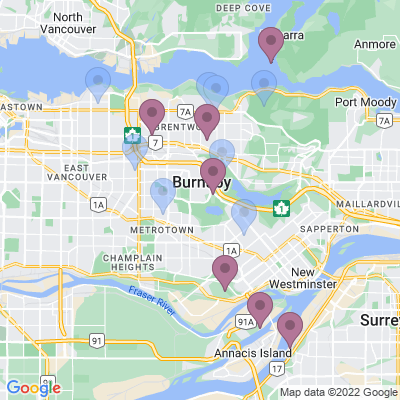

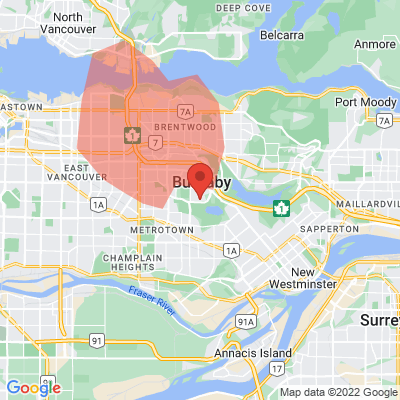

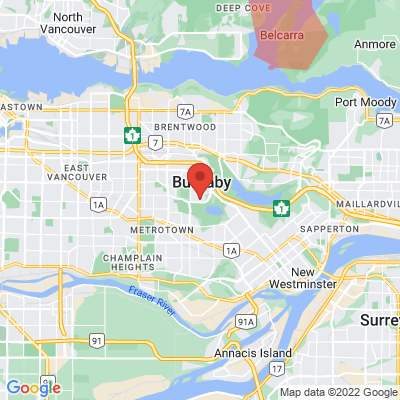

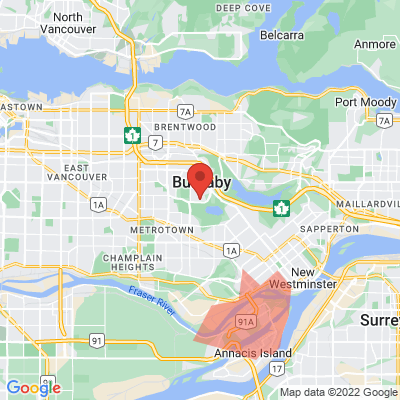

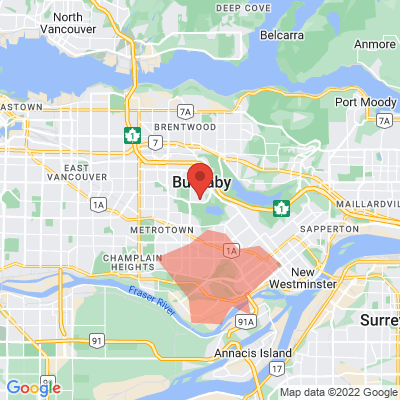

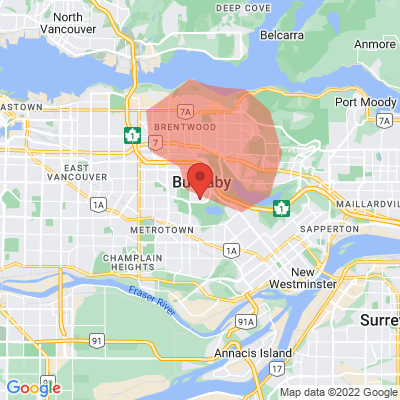

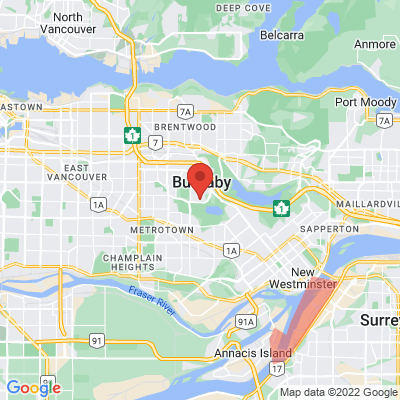

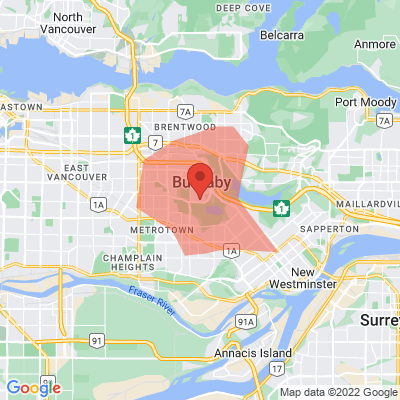

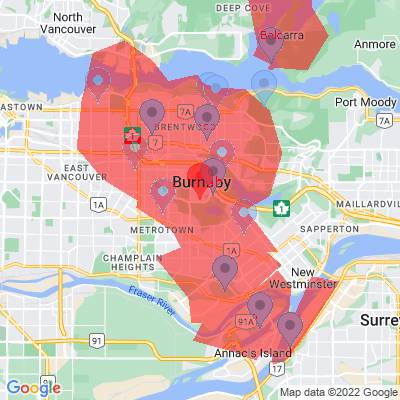

In [157]:
print(linprog_solution)
display_solution(test_problem_burnaby_center, test_problem_burnaby_locations, linprog_solution, show_coverage=True)